In [1]:
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import libpysal
import numpy as np
import pandas as pd
import json
import requests

from osm2geojson import json2shapes
from shapely.geometry import Polygon, polygon

In [2]:
def osm_lu_classifier(lon, lat, buffer):
    
    # Get the raw data from overpass
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = f"""
    [timeout:25][out:json];
    ( way(around:{buffer},{lat},{lon})(if:is_closed()==1)[landuse];
      way(around:{buffer},{lat},{lon})(if:is_closed()==1)[leisure];
      way(around:{buffer},{lat},{lon})(if:is_closed()==1)[natural];
      way(around:{buffer},{lat},{lon})(if:is_closed()==1)[tourism];
      way(around:{buffer},{lat},{lon})(if:is_closed()==1)[waterway];  
      relation(around:{buffer},{lat},{lon})(if:is_closed()==1)[landuse];
      relation(around:{buffer},{lat},{lon})(if:is_closed()==1)[leisure];
      relation(around:{buffer},{lat},{lon})(if:is_closed()==1)[natural];
      relation(around:{buffer},{lat},{lon})(if:is_closed()==1)[tourism];
      relation(around:{buffer},{lat},{lon})(if:is_closed()==1)[waterway];  
    );  
    (._;>;);
    out body;
    """
    
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    
    # Load gdf and clip to area of interest
    shapes_data = json2shapes(data)
    gdf = gpd.GeoDataFrame({'tags':[i['properties']['tags'] for i in shapes_data], 'geometry': [i['shape'] for i in shapes_data]}, crs='EPSG:4326').to_crs('EPSG:27700')
    point_buffer = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(x=[lon],y=[lat])},crs='EPSG:4326').to_crs('EPSG:27700').buffer(buffer)
    gdf = gdf.clip(point_buffer).reset_index(drop=True)
    
    # Flatten by removing overlapping areas
    W = libpysal.weights.fuzzy_contiguity(gdf.geometry, predicate='intersects', tolerance=0)
    gdf['component_labels'] = W.component_labels
    gdf_new = gdf.copy()

    for group_index, group in gdf_new.groupby('component_labels'):
        if group.shape[0] > 1:
            for i in gdf_new[gdf_new['component_labels']==group.component_labels.values[0]].index:
                for j in gdf_new[gdf_new['component_labels']==group.component_labels.values[0]].index:
                    if j < i:

                        intersection = gdf_new[gdf_new.index==i].overlay(gdf_new[gdf_new.index==j], how='intersection', keep_geom_type=False)
                        diff_i = gdf_new[gdf_new.index==i].overlay(gdf_new[gdf_new.index==j], how='difference', keep_geom_type=False)
                        diff_j = gdf_new[gdf_new.index==j].overlay(gdf_new[gdf_new.index==i], how='difference', keep_geom_type=False)

                        if intersection.geometry.area.sum() > 0:
                            if len(diff_i) > 0 and len(diff_j) > 0:           
                                if diff_i.geometry.area.values[0] < diff_j.geometry.area.values[0]:
                                    gdf_new.loc[[j],'geometry'] = diff_j.geometry.values
                                else:
                                    gdf_new.loc[[i],'geometry'] = diff_i.geometry.values
                                    
                            if len(diff_j)==0 and diff_i.geometry.values[0] is not None:
                                gdf_new.loc[[i], 'geometry'] = diff_i.geometry.values
                            if len(diff_i)==0 and diff_j.geometry.values[0] is not None:
                                gdf_new.loc[[j],'geometry'] = diff_j.geometry.values

    # Do the classification
    gdf_new = gdf_new.merge(gdf_new['tags'].apply(pd.Series), left_index=True, right_index=True)
    
    columns_of_interest = list(set(['tourism', 'leisure', 'natural', 'landuse']).intersection(set(gdf_new.columns)))    
    
    if len(columns_of_interest) == 0:
        return None, None, gdf_new
    elif len(columns_of_interest) == 1:
        gdf_new['lu_class'] = gdf_new[columns_of_interest[0]]
    elif len(columns_of_interest) == 2:
        gdf_new['lu_class'] = gdf_new[columns_of_interest[0]].combine_first(gdf_new[columns_of_interest[1]])
    elif len(columns_of_interest) == 3:
        gdf_new['lu_class'] = gdf_new[columns_of_interest[0]].combine_first(gdf_new[columns_of_interest[1]].combine_first(gdf_new[columns_of_interest[2]]))
    else:
        gdf_new['lu_class'] = gdf_new[columns_of_interest[0]].combine_first(gdf_new[columns_of_interest[1]].combine_first(gdf_new[columns_of_interest[2]].combine_first(gdf_new[columns_of_interest[3]])))
    gdf_new['area'] = gdf_new.area

    lu_classifier = (gdf_new.groupby('lu_class')['area'].sum() / gdf_new.groupby('lu_class')['area'].sum().sum()).sort_values(ascending=False)
    coverage = (100 * (gdf_new.area.sum() / (np.pi * (500 ** 2))))
    
    return lu_classifier, coverage, gdf_new

In [8]:
lu_classification, coverage, gdf = osm_lu_classifier(lon=-0.603353, lat=51.174312, buffer=500)

In [9]:
lu_classification

lu_class
residential    0.477381
farmland       0.436715
wood           0.066612
allotments     0.009991
religious      0.004926
pitch          0.004375
Name: area, dtype: float64

In [5]:
print('%% coverage = %.2f' % (coverage))

% coverage = 71.60


<AxesSubplot:>

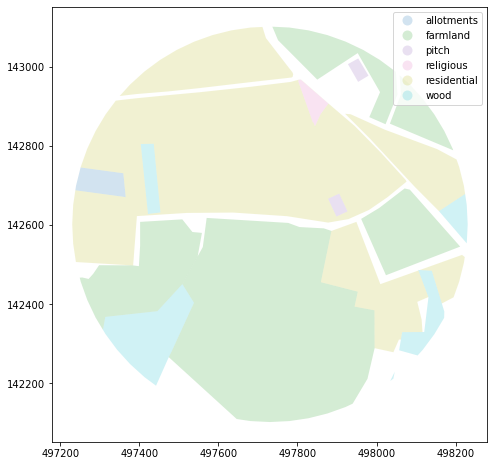

In [11]:
gdf.plot('lu_class', categorical=True, figsize=(8,8), alpha=0.2, legend=True)